In [1]:
using GeneralizedSasakiNakamura

In [2]:
using SpinWeightedSpheroidalHarmonics

In [3]:
using Plots, LaTeXStrings

In [4]:
M=1;
s=1;

In [5]:
l = 1;
m = 1;

In [6]:
a_values  = [0.99];
omegas = collect(0.01:0.01:0.6);

greybody_factors = Dict()
reflectivity_from_inf_rotating_charged = Dict()
ratios_dict = Dict()

Dict{Any, Any}()

In [7]:
for a in a_values
    reflectivity_from_inf_rotating_charged[a] = ComplexF64[]
    ratios_dict[a] = Float64[]

    for omg in omegas
        Xin = GSN_radial(s, l, m, a, omg, IN, -20, 250)
        push!(reflectivity_from_inf_rotating_charged[a], Xin.reflection_amplitude / Xin.incidence_amplitude)
        lamda = spin_weighted_spheroidal_eigenvalue(s, l, m, a * omg)
        Q = lamda + s * (s + 1)
        c0 = -2-lamda
        Bsq = Q^2 + 4 * m * a * omg - 4 * a^2 * omg^2
        ratio =  (abs(c0))^2/ Bsq 
        push!(ratios_dict[a], ratio)
    end

    greybody_factors[a] = 1 .- ratios_dict[a] .* abs.(reflectivity_from_inf_rotating_charged[a]).^2
end

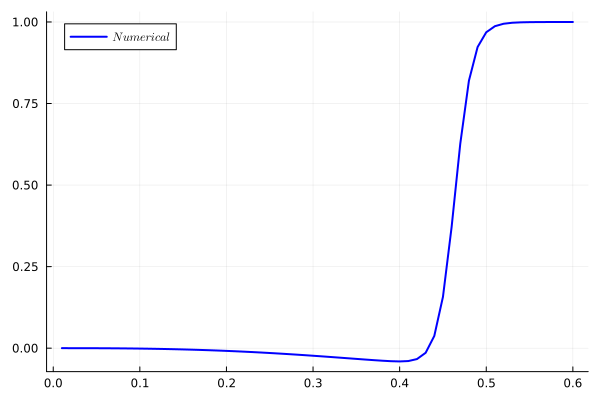

In [8]:
plt = plot(omegas, greybody_factors[0.99], linewidth=2, linestyle=:solid, color=:blue, label=L"Numerical")

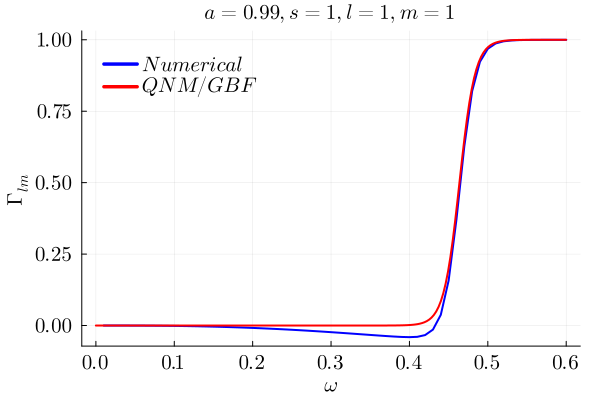

In [9]:

GreyBodyEikonal0(w0) = x -> -im * (x^2 - real(w0)^2) / (4 * real(w0) * imag(w0))
GreyBodyEikonal01(w0, w1) = x -> -im * (x^2 - real(w0)^2) / (4 * real(w0) * imag(w0)) + 
                                im * (real(w0) - real(w1)) / (16 * imag(w0))
GreyBodyEikonal012(w0, w1) = x -> begin
    term1 = -im * (x^2 - real(w0)^2) / (4 * real(w0) * imag(w0)) * 
            (1 + (real(w0) - real(w1))^2 / (32 * imag(w0)^2) - 
             (3 * imag(w0) - imag(w1)) / (24 * imag(w0)))
    
    term2 = im * (real(w0) - real(w1)) / (16 * imag(w0))
    
    term3 = im * (x^2 - real(w0)^2)^2 / (16 * imag(w0) * real(w0)^2) * 
            (1 / real(w0) + (real(w0) - real(w1))^2 / (4 * imag(w0)^2))
    
    return term1 + term2 + term3
end
GreyBodyEikonal0125(w0, w1) = x -> begin
    term1 = -im * (x^2 - real(w0)^2) / (4 * real(w0) * imag(w0)) * 
            (1 + (real(w0) - real(w1))^2 / (32 * imag(w0)^2) - 
             (3 * imag(w0) - imag(w1)) / (24 * imag(w0)))
    term2 = im * (real(w0) - real(w1)) / (16 * imag(w0))
    term3 = im * (x^2 - real(w0)^2)^2 / (16 * imag(w0) * real(w0)^2) * 
            (1 / real(w0) + (real(w0) - real(w1))^2 / (4 * imag(w0)^2))
    term4 = -im * (x^2 - real(w0)^2)^3 / (32 * real(w0)^5 * imag(w0)) * 
            (1 + ((real(w0) - real(w1)) * real(w0)) / (4 * imag(w0)^2) + 
             ((real(w0) - real(w1))^2 * real(w0)^2) / (16 * imag(w0)^4) - 
             ((3 * imag(w0) - imag(w1)) * real(w0)^2) / (12 * imag(w0)^3))
    return term1 + term2 + term3 + term4
end

GBF(x) = (1 + exp(2*im * π * x))^-1



w0w1_params = [
    (0.46339877110045397-0.03129241298313222im, 0.4602335879364111-0.09143056158218439im),
]



ω_range = range(0.0, 0.6, length=200)

for (i,(w0, w1)) in enumerate(w0w1_params)
    GBE0125 = GreyBodyEikonal0125(w0, w1)
    global y_GBE0125 = real(GBF.(GBE0125.(ω_range)))
    plot!(plt, ω_range, y_GBE0125, linewidth=2, linestyle=:solid, color=:red, label=L"QNM/GBF")
end

plot!(plt,
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:best,
    formatter=:latex,
    xlabel=L"\omega",
    ylabel=L"\Gamma_{lm}",
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm,
 )
title!(plt, L"a=0.99,s=1,l=1,m=1")

In [10]:
function hawking_temperature(a)
rp=GeneralizedSasakiNakamura.Kerr.r_plus(a)
rm=GeneralizedSasakiNakamura.Kerr.r_minus(a)
return (rp - rm)/(4*π*(rp^2 + a^2))
end

hawking_temperature (generic function with 1 method)

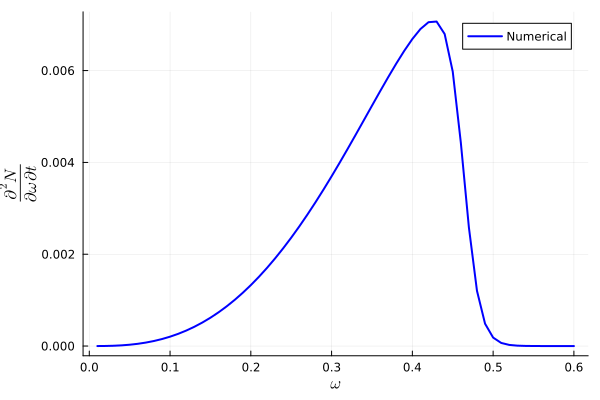

In [11]:
function number_emission_rate(omegas, Γ; T_H, N=1, Ω_H=nothing, m)
    T_H == 0 && return zero.(omegas)
    x = Ω_H === nothing ? omegas ./ T_H : (omegas .- m * Ω_H) ./ T_H
    denom = expm1.(x)  
    return (N / (2*π))   .* (Γ ./ denom)
end

emission_rates = Dict{Float64, Vector{Float64}}()
for a in a_values
    T_H = hawking_temperature(a)
    Ω_H = GeneralizedSasakiNakamura.Kerr.omega_horizon(a)
    Γ = greybody_factors[a]
    emission_rates[a] = number_emission_rate(omegas, Γ; T_H=T_H, N=1, Ω_H=Ω_H, m=m)
end

plt = plot()
for a in a_values
    plot!(plt, omegas, emission_rates[0.99], linewidth=2,color=:blue, label="Numerical")
end
xlabel!(plt, L"\omega")
ylabel!(plt, L"\frac{\partial^2 N}{\partial \omega\,\partial t}")

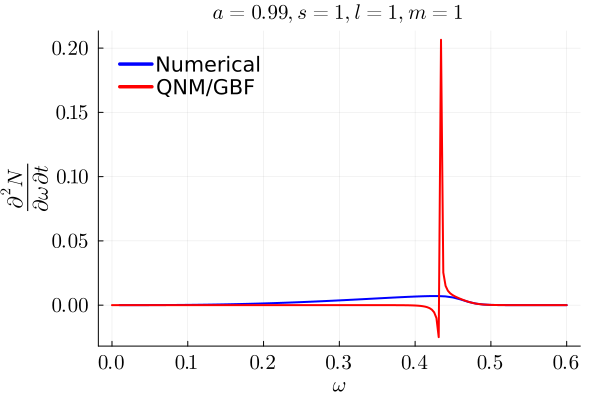

In [12]:
ner_gbf = Dict{Float64, Vector{Float64}}()

ω_gbf = collect(ω_range)
Γ_gbf = y_GBE0125

for a in a_values
    T_H = hawking_temperature(a)
    Ω_H = GeneralizedSasakiNakamura.Kerr.omega_horizon(a)
    ner_gbf[a] = number_emission_rate(ω_gbf, Γ_gbf; T_H=T_H, N=1, Ω_H=Ω_H, m=m)
end

plt_ner_gbf = plot!()
for a in a_values
    plot!(plt_ner_gbf, ω_gbf, ner_gbf[a], linewidth=2, linestyle=:solid, color=:red, label="QNM/GBF")
end

plot!(plt_ner_gbf,
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topleft,
    formatter=:latex,
    xlabel=L"\omega",
    ylabel=L"\frac{\partial^2 N}{\partial \omega\,\partial t}",
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm,
 )
title!(plt_ner_gbf, L"a=0.99,s=1,l=1,m=1")
